# 1. 환경 설정

In [ ]:
# 라이브러리 설정
import pandas as pd
import numpy as np
import tensorflow as tf
import random

# 랜덤 시드 고정
SEED=12
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)  

# 구글 드라이브 폴더 마운트
from google.colab import drive, files
drive.mount('/gdrive')

Mounted at /gdrive


# 2. 데이터셋 준비

In [ ]:
# 데이콘 사이트에서 다운로드한 CSV파일을 읽어오기
drive_path = "/gdrive/My Drive/"
train = pd.read_csv(drive_path + "mnist_data/train.csv")
test = pd.read_csv(drive_path + "mnist_data/test.csv")
submission = pd.read_csv(drive_path + "mnist_data/sample_submission.csv")

print(train.shape, test.shape, submission.shape)   

(60000, 786) (10000, 785) (10000, 2)


In [ ]:
# train 데이터 보기
train.head()

index  label  pixel1  pixel2  ...  pixel781  pixel782  pixel783  pixel784
0      0      2       0       0  ...         0         0         0         0
1      1      9       0       0  ...         0         0         0         0
2      2      6       0       0  ...         0         0         0         0
3      3      0       0       0  ...         0         0         0         0
4      4      3       0       0  ...         0         0         0         0

[5 rows x 786 columns]

In [ ]:
# train 데이터를 28*28 이미지로 변환
train_images = train.loc[:, 'pixel1':].values.reshape(-1, 28, 28)
train_images.shape

(60000, 28, 28)

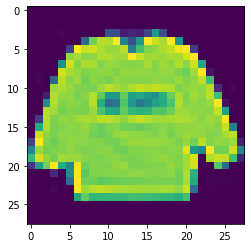

In [ ]:
# 첫번째 이미지 출력
import matplotlib.pyplot as plt
plt.imshow(train_images[0]);

In [ ]:
# 목표 레이블 
y_train = train.loc[:, 'label']
y_train.unique()

array([2, 9, 6, 0, 3, 4, 5, 8, 7, 1])

In [ ]:
# 숫자 레이블을 실제 레이블과 연결하여 확인
target_values = {0 : 'T-shirt/top', 
                 1 : 'Trouser', 
                 2: 'Pullover', 
                 3: 'Dress', 
                 4: 'Coat', 
                 5: 'Sandal', 
                 6: 'Shirt', 
                 7: 'Sneaker', 
                 8: 'Bag', 
                 9: 'Ankle boot'}
print(y_train[0])
print(target_values[y_train[0]])

2
Pullover


In [ ]:
# test 데이터를 28*28 이미지로 변환
test_images = test.loc[:, 'pixel1':].values.reshape(-1, 28, 28)
test_images.shape

(10000, 28, 28)

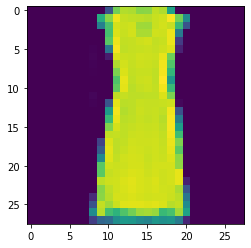

In [ ]:
# 500번째 test 이미지를 출력
plt.imshow(test_images[499]);

# 2. 데이터 전처리 (Pre-processing)

In [ ]:
# 피처 스케일 맞추기 
X_train = train_images / 255.
X_test = test_images / 255.
print("최소값:", X_train[0].min())
print("최대값:", X_train[0].max())

최소값: 0.0
최대값: 1.0


In [ ]:
# 채널 차원 추가
print("변환 전:", X_train.shape, X_test.shape)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
print("변환 후:", X_train.shape, X_test.shape)

변환 전: (60000, 28, 28) (10000, 28, 28)
변환 후: (60000, 28, 28, 1) (10000, 28, 28, 1)


In [ ]:
# Train - Validation 데이터 구분
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val =  train_test_split(X_train, y_train, test_size=0.2, 
                                             stratify=y_train, 
                                             shuffle=True, random_state=SEED)
print("학습 데이터셋 크기: ", X_tr.shape, y_tr.shape)
print("검증 데이터셋 크기: ", X_val.shape, y_val.shape)

학습 데이터셋 크기:  (48000, 28, 28, 1) (48000,)
검증 데이터셋 크기:  (12000, 28, 28, 1) (12000,)


# 3. 모델 구축

### MLP 모델

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
mlp_model = Sequential()
mlp_model.add(Flatten(input_shape=[28, 28]))
mlp_model.add(Dense(units=64, activation='relu'))
mlp_model.add(Dense(units=10, activation='softmax'))

mlp_model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['acc'])

mlp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


In [ ]:
mlp_history = mlp_model.fit(X_tr, y_tr, batch_size=64, epochs=20,
                        validation_data=(X_val, y_val),
                        verbose=2)

Epoch 1/20
750/750 - 2s - loss: 0.5735 - acc: 0.8021 - val_loss: 0.4506 - val_acc: 0.8426
Epoch 2/20
750/750 - 1s - loss: 0.4224 - acc: 0.8495 - val_loss: 0.4086 - val_acc: 0.8578
Epoch 3/20
750/750 - 1s - loss: 0.3868 - acc: 0.8620 - val_loss: 0.3947 - val_acc: 0.8612
Epoch 4/20
750/750 - 1s - loss: 0.3618 - acc: 0.8704 - val_loss: 0.3895 - val_acc: 0.8607
Epoch 5/20
750/750 - 1s - loss: 0.3449 - acc: 0.8758 - val_loss: 0.3753 - val_acc: 0.8690
Epoch 6/20
750/750 - 1s - loss: 0.3283 - acc: 0.8806 - val_loss: 0.3484 - val_acc: 0.8783
Epoch 7/20
750/750 - 1s - loss: 0.3167 - acc: 0.8856 - val_loss: 0.3467 - val_acc: 0.8789
Epoch 8/20
750/750 - 1s - loss: 0.3049 - acc: 0.8901 - val_loss: 0.3495 - val_acc: 0.8737
Epoch 9/20
750/750 - 1s - loss: 0.2959 - acc: 0.8931 - val_loss: 0.3440 - val_acc: 0.8795
Epoch 10/20
750/750 - 1s - loss: 0.2889 - acc: 0.8949 - val_loss: 0.3762 - val_acc: 0.8717
Epoch 11/20
750/750 - 2s - loss: 0.2788 - acc: 0.8985 - val_loss: 0.3441 - val_acc: 0.8799
Epoch 12

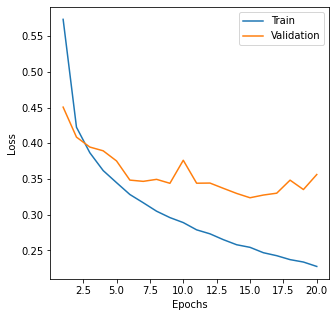

In [ ]:
# 손실 함수 그래프
def plot_loss_curve(history, total_epoch=10, start=1):
    plt.figure(figsize=(5, 5))
    plt.plot(range(start, total_epoch + 1), 
             history.history['loss'][start-1:total_epoch], 
             label='Train')
    plt.plot(range(start, total_epoch + 1), 
             history.history['val_loss'][start-1:total_epoch], 
             label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss_curve(history=mlp_history, total_epoch=20, start=1)                   

### CNN 활용

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
cnn_model = Sequential()
cnn_model.add(Conv2D(filters=16, kernel_size=(3, 3), 
                    activation='relu', input_shape=[28, 28, 1]))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(units=64, activation='relu'))
cnn_model.add(Dense(units=10, activation='softmax'))

cnn_model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['acc'])

cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2704)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                173120    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 173,930
Trainable params: 173,930
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cnn_history = cnn_model.fit(X_tr, y_tr, batch_size=64, epochs=20,
                        validation_data=(X_val, y_val),
                        verbose=2) 

Epoch 1/20
750/750 - 2s - loss: 0.4934 - acc: 0.8274 - val_loss: 0.3743 - val_acc: 0.8667
Epoch 2/20
750/750 - 2s - loss: 0.3340 - acc: 0.8813 - val_loss: 0.3110 - val_acc: 0.8920
Epoch 3/20
750/750 - 2s - loss: 0.2909 - acc: 0.8966 - val_loss: 0.3032 - val_acc: 0.8917
Epoch 4/20
750/750 - 2s - loss: 0.2625 - acc: 0.9063 - val_loss: 0.2901 - val_acc: 0.8944
Epoch 5/20
750/750 - 2s - loss: 0.2411 - acc: 0.9138 - val_loss: 0.2896 - val_acc: 0.8996
Epoch 6/20
750/750 - 2s - loss: 0.2232 - acc: 0.9209 - val_loss: 0.2735 - val_acc: 0.9024
Epoch 7/20
750/750 - 2s - loss: 0.2033 - acc: 0.9266 - val_loss: 0.2677 - val_acc: 0.9047
Epoch 8/20
750/750 - 2s - loss: 0.1871 - acc: 0.9320 - val_loss: 0.2584 - val_acc: 0.9064
Epoch 9/20
750/750 - 2s - loss: 0.1741 - acc: 0.9383 - val_loss: 0.2548 - val_acc: 0.9124
Epoch 10/20
750/750 - 2s - loss: 0.1626 - acc: 0.9419 - val_loss: 0.2657 - val_acc: 0.9078
Epoch 11/20
750/750 - 2s - loss: 0.1516 - acc: 0.9442 - val_loss: 0.2589 - val_acc: 0.9116
Epoch 12

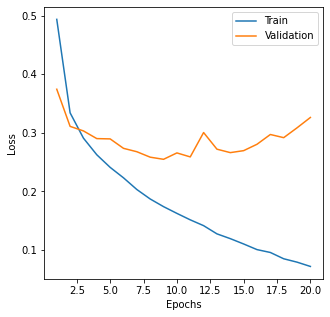

In [ ]:
plot_loss_curve(history=cnn_history, total_epoch=20, start=1)    

In [ ]:
from tensorflow.keras.layers import Dropout
def build_cnn():
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=(3, 3), 
                     activation='relu', input_shape=[28, 28, 1]))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=10, activation='softmax'))

    model.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy', 
                metrics=['acc'])

    return model

cnn_model = build_cnn()
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2704)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                173120    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                650       
Total params: 173,930
Trainable params: 173,930
Non-trainable params: 0
________________________________________________

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',  patience=10)

cnn_history = cnn_model.fit(X_tr, y_tr, batch_size=64, epochs=100,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping],
                        verbose=0) 

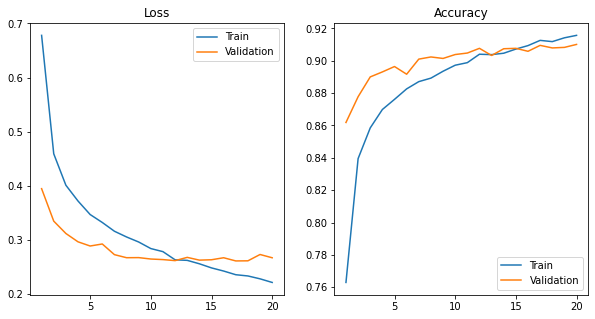

In [ ]:
# 20 epoch 까지 손실함수와 정확도를 그래프로 나타내기
start=1
end = 20

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(range(start, end+1), cnn_history.history['loss'][start-1:end], 
             label='Train')
axes[0].plot(range(start, end+1), cnn_history.history['val_loss'][start-1:end], 
             label='Validation')
axes[0].set_title('Loss')
axes[0].legend()

axes[1].plot(range(start, end+1), cnn_history.history['acc'][start-1:end], 
             label='Train')
axes[1].plot(range(start, end+1), cnn_history.history['val_acc'][start-1:end], 
             label='Validation')
axes[1].set_title('Accuracy')
axes[1].legend()
plt.show()

In [ ]:
cnn_model.evaluate(X_val, y_val)

375/375 [==============================] - 1s 2ms/step - loss: 0.2920 - acc: 0.9120


[0.2920343577861786, 0.9120000004768372]

In [ ]:
y_pred_proba = cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_proba, axis=-1)
y_pred_classes[:10]

array([0, 1, 6, 6, 3, 6, 8, 6, 5, 0])

In [ ]:
submission['label'] = y_pred_classes
submission_filepath = drive_path + 'mnist_cnn_submission1.csv'   
submission.to_csv(submission_filepath, index=False)

In [ ]:
# 사용자 정의 콜백 함수
from tensorflow.keras.callbacks import Callback

class my_callback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_acc') > 0.91):
      self.model.stop_training = True
      print("\n")
      print("목표 정확도 달성: 검증 정확도 %.4f" % logs.get('val_acc'))

my_callback = my_callback()

# Best Model 저장
from tensorflow.keras.callbacks import ModelCheckpoint

best_model_path = drive_path + "best_cnn_model.h5"
save_best_model = ModelCheckpoint(best_model_path, monitor='val_loss', 
                                  save_best_only=True, save_weights_only=False)

# CNN 모델 학습
cnn_model = build_cnn()
cnn_history = cnn_model.fit(X_tr, y_tr, batch_size=64, epochs=100,
                        validation_data=(X_val, y_val),
                        callbacks=[my_callback, save_best_model],
                        verbose=2) 

Epoch 1/100
750/750 - 2s - loss: 0.6587 - acc: 0.7705 - val_loss: 0.3907 - val_acc: 0.8620
Epoch 2/100
750/750 - 2s - loss: 0.4471 - acc: 0.8447 - val_loss: 0.3341 - val_acc: 0.8806
Epoch 3/100
750/750 - 2s - loss: 0.3912 - acc: 0.8646 - val_loss: 0.3133 - val_acc: 0.8870
Epoch 4/100
750/750 - 2s - loss: 0.3608 - acc: 0.8744 - val_loss: 0.2983 - val_acc: 0.8903
Epoch 5/100
750/750 - 2s - loss: 0.3365 - acc: 0.8814 - val_loss: 0.2886 - val_acc: 0.8937
Epoch 6/100
750/750 - 2s - loss: 0.3206 - acc: 0.8857 - val_loss: 0.2846 - val_acc: 0.8971
Epoch 7/100
750/750 - 2s - loss: 0.3043 - acc: 0.8906 - val_loss: 0.2766 - val_acc: 0.8999
Epoch 8/100
750/750 - 2s - loss: 0.2933 - acc: 0.8956 - val_loss: 0.2711 - val_acc: 0.9020
Epoch 9/100
750/750 - 2s - loss: 0.2855 - acc: 0.8967 - val_loss: 0.2684 - val_acc: 0.9000
Epoch 10/100
750/750 - 2s - loss: 0.2725 - acc: 0.9009 - val_loss: 0.2718 - val_acc: 0.9032
Epoch 11/100
750/750 - 2s - loss: 0.2642 - acc: 0.9039 - val_loss: 0.2614 - val_acc: 0.90

In [ ]:
from tensorflow.keras.models import load_model
# ModelCheckPoint에 저장해둔 모델을 로딩 
best_model = load_model(drive_path + "best_cnn_model.h5")
best_model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 13, 13, 16)        0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 2704)              0         
_________________________________________________________________
dense_44 (Dense)             (None, 64)                173120    
_________________________________________________________________
dropout_20 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 10)                650       
Total params: 173,930
Trainable params: 173,930
Non-trainable params: 0
_______________________________________________

In [ ]:
y_pred_proba = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_proba, axis=-1)
submission['label'] = y_pred_classes
submission_filepath = drive_path + 'mnist_cnn_submission2.csv'   
submission.to_csv(submission_filepath, index=False)